# Table des matières

### [Importation du jeu de données](#T1)
- [Importation des librairies](#T1C1)
- [Importation du jeu de données](#T1C2)
- [Fonctions](#T1C3)

### [Développement du modèle : LogisticRegression](#T2)
- [Score métier](#T2C1)
- [Recherche du meilleur seuil](#T2C2)
- [Recherche des meilleurs hyperparamètres](#T2C3)
- [Quelques observation sur le modèle](#T2C4)
- [Enregistrement du modèle](#T2C5)

### [Dérive du modèle](#T3)
- [Evidently](#T3C1)
- [Résultat](#T3C2)

### [Conclusions générales](#C)

***
# <a name="T1">Importation du jeu de données</a>

### <a name = "T1C1">a. Importation des librairies</a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
import imblearn
import shap
import random
import mlflow
import copy
import pickle
import shap

from datetime import datetime
from IPython.display import clear_output, IFrame

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, fbeta_score

from imblearn.pipeline import Pipeline # sklearn ne prend pas en compte les méthodes de sampling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from mlflow.sklearn import log_model, save_model, autolog

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

libraries = {
    "Pandas" : pd,
    "Numpy" : np,
    "Scikit-Learn" : sklearn,
    "Imblearn" : imblearn,
    "mlflow" : mlflow,
}

# On affiche les différentes versions des librairies utilisées
for lib_name, lib in libraries.items():
    print(f"{lib_name} Version : {lib.__version__}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Blowfish has been deprecated


Pandas Version : 1.5.3
Numpy Version : 1.23.5
Scikit-Learn Version : 1.2.2
Imblearn Version : 0.11.0
mlflow Version : 2.6.0


### <a name = "T1C2">b. Importation du jeu de données</a>

In [2]:
#https://www.kaggle.com/code/mohammad2012191/reduce-memory-usage-2gb-780mb
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("L'utilisation de la mémoire est de {:.2f} MB".format(start_mem))
    
    for i, col in enumerate(df.columns, start=1):
        col_type = df[col].dtype

        # Calculate the percentage of completion
        completion_percentage = (i / df.shape[1]) * 100

        # Use \r to move the cursor to the beginning of the line and overwrite the previous output
        print(f"({i}/{df.shape[1]}) - {completion_percentage:.2f}% complete", end='\r')

        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print("L'utilisation de la mémoire est de {:.2f} MB après optimisation".format(end_mem))
    print("Réduction de {:.1f} %".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [3]:
data = pd.read_csv("fichiers/concatenate_files.csv")
# On réduit la taille du fichier
data = reduce_mem_usage(data)

L'utilisation de la mémoire est de 1869.84 MB
L'utilisation de la mémoire est de 515.26 MB après optimisation
Réduction de 72.4 %


### <a name = "T1C3">c. Fonctions</a>

On utilise les mêmes fonctions que dans le précédent notebook

In [4]:
# Reprise des explications du kaggle.
# La plupart des features sont créées en appliquant les fonctions min, max, moyenne, somme et var.
# - La division de certaines features permet d'obtenir des taux (comme la rente et le revenu)
# - Dans Bureau Data : créer des features spécifiques pour les crédits actifs et les crédits clôturés
# - Dans Previous Applications : on a des features spécifiques pour les candidatures approuvées et refusées
# - On réalise un One Hot encodage pour les featurees catégoriques
# Tous les fichiers sont joints au fichier application avec SK_ID_CURR (sauf bureau_balance).


# Pour limiter le nombre d'entrées, lors de test
DEBUG = None # 10000

# Permet de réaliser le One Hot encodage
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess les fichiers application_train.csv / application_test.csv 
def application_train_test(file, nan_as_category = False):
    df = pd.read_csv(file, nrows = DEBUG)
    print("Samples: {}".format(len(df)))
    
    # On élimine les entrées CODE_GENDER == XNA (genre non spécifié) et qui ne concernent que peu de clients
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # On encode par 0 ou 1 quand il n'y a que 2 catégories
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Sinon on fait du one hot encoding
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # On remplace les erreurs entrées par des np.NaN 
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Quelques features créées par feature engineering
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # On met en positif, puis on divise par 365 pour avoir le nombre d'années
    df["ANNEES_AGE"] = round((abs(df.DAYS_BIRTH) / 365.25), 1)
    df["ANNEES_EMPLOYED"] = round((abs(df.DAYS_EMPLOYED) / 365.25), 1)
    df["ANNEES_LAST_PHONE_CHANGE"] = round((abs(df.DAYS_LAST_PHONE_CHANGE) / 365.25), 2)    
    
    # On élimine les anciennes variables
    df.drop(["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_LAST_PHONE_CHANGE"], axis = 1, inplace = True)
    
    return df

# Preprocess les fichiers bureau.csv et bureau_balance.csv
def bureau_and_balance(file_bureau = "fichiers/bureau.csv", file_bb = "fichiers/bureau_balance.csv", nan_as_category = True):
    bureau = pd.read_csv(file_bureau, nrows = DEBUG)
    bb = pd.read_csv(file_bb, nrows = DEBUG)
    
    # On réalise un One Hot encodage
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance : On réalise une aggrégation puis on fusionne avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Elimination des dataframes pour libérer de la mémoire
    del bb, bb_agg
    
    
    # On réalise différentes aggrégations sur les features numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    # Elimination des dataframes pour libérer de la mémoire
    del active, active_agg
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    # Elimination des dataframes pour libérer de la mémoire
    del closed, closed_agg, bureau
    
    return bureau_agg

# Preprocess du fichier previous_applications.csv
def previous_applications(file = "fichiers/previous_application.csv", nan_as_category = True):
    prev = pd.read_csv(file, nrows = DEBUG)
    # One hot encodage
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # On remplace les erreurs entrées par des np.NaN 
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Feature engineering : valeur demandée / valeur reçue 
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Correction
    prev['APP_CREDIT_PERC'] = prev['APP_CREDIT_PERC'].apply(lambda x: 0 if (x == np.nan) or (x == np.inf) else x)
    # Features numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Features catégoriques
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # On aggrége sur les anciennes applications qui ont été acceptées 
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # On aggrége sur les anciennes applications qui ont été refusées 
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # Elimination des dataframes pour libérer de la mémoire
    del refused, refused_agg, approved, approved_agg, prev
    
    return prev_agg

# Preprocess fichier POS_CASH_balance.csv
def pos_cash(file = "fichiers/POS_CASH_balance.csv", nan_as_category = True):
    pos = pd.read_csv(file, nrows = DEBUG)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # On compte le nombre de POS compte
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Elimination du dataframe pour libérer de la mémoire
    del pos
    
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(file = "fichiers/installments_payments.csv", nan_as_category = True):
    ins = pd.read_csv(file, nrows = DEBUG)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Quelques features créées par feature engineering
    # Pourcentage et différence payées sur les différents prêts (Pourcentage payé et ce qu'il reste à payer)
    ins['AMT_PAYMENT'] = ins['AMT_PAYMENT'].apply(lambda x: x if x >= 0 else 0)
    ins['PAYMENT_EFFECTUE_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_EFFECTUE_PERC'] = ins['PAYMENT_EFFECTUE_PERC'].apply(lambda x: 0 if (x == np.nan) or (x == np.inf) else x)
    ins['PAYMENT_RESTANT'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # On différencie les : jours en retard de paiement (DPD) et jours avant paiement (DBD)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_EFFECTUE_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_RESTANT': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Elimination du dataframe pour libérer de la mémoire
    del ins
    
    return ins_agg

# Preprocess le fichier credit_card_balance.csv
def credit_card_balance(file = "fichiers/credit_card_balance.csv", nan_as_category = True):
    cc = pd.read_csv(file, nrows = DEBUG)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    # Elimination du dataframe pour libérer de la mémoire
    del cc
    
    return cc_agg  

# Fonction permettant de créer le fichier .csv

def creation_fichier_csv(df, nom_du_fichier):

    ## On identifie si le format CSV a été entré, sinon on l'ajout
    if ".csv" not in nom_du_fichier:
        nom_du_fichier = nom_du_fichier + ".csv"

    ## Le fichier est écrit au même endroit que le notebook
    ## Séparateur : virgule
    df.to_csv(nom_du_fichier, index = False, sep = ",")

def preparation_files(bool_drift = False):
    ##
    #    Fonction appelant les autres fonctions de préparation d'un fichier mergé
    #    On appel la même fonction pour créer le fichier permettant le test de data drift
    ##
    
    if bool_drift == False:
        df = application_train_test(file="fichiers/application_train.csv")
    elif bool_drift == True:
        print("Préparation des fichiers pour une analyse du data_drift")
        df = application_train_test(file="fichiers/application_test.csv")
        
    print("Préparation des fichiers : bureau and bureau_balance")
    bureau = bureau_and_balance()
    print("Taille du fichier Bureau :", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau

    print("Préparation du fichier : previous_applications")
    prev = previous_applications()
    print("Taille du fichier Previous applications :", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev

    print("Préparation du fichier : POS-CASH balance")
    pos = pos_cash()
    print("Taille du fichier Pos-cash balance :", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos

    print("Préparation du fichier : installments payments")
    ins = installments_payments()
    print("Taille du fichier Installments payments :", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins

    print("Préparation du fichier : credit card balance")
    cc = credit_card_balance()
    print("Taille du fichier Credit card balance :", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc

    print("Création du fichier mergé...")
    # On créé le fichier avec les données fusionnées
    if bool_drift == False :
        creation_fichier_csv(df, "fichiers/concatenate_files.csv")
    elif bool_drift == True :
        creation_fichier_csv(df, "fichiers/concatenate_files_data_drift.csv")
    
    print("Fichier généré !")
    return df

In [5]:
# On crée un transformer personnalisé sur la sélection des colonnes
# On rajoute un élément permettant d'ignorer les colonnes manquantes
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns, ignore_missing=False):
        self.columns = columns
        self.ignore_missing = ignore_missing

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.ignore_missing:
            selected_columns = [col for col in self.columns if col in X.columns]
        else:
            selected_columns = self.columns

        return X[selected_columns]

In [6]:
def extract_confusion_matrix_metrics(confusion_m):
    ##
    # Fonction extraction les valeurs de la matrice de confusion
    # Retourne sous la forme d'un dictionnaire
    ##
    vn = confusion_m[0, 0]  # vrais négatifs
    vp = confusion_m[1, 1]  # vrais positifs
    fp = confusion_m[0, 1]  # faux positifs
    fn = confusion_m[1, 0]  # faux negatifs
    
    valeurs_matrice = {
        "VN": vn,
        "VP": vp,
        "FP": fp,
        "FN": fn
    }
    
    return valeurs_matrice


In [7]:
# Fonction affichant la matrice de confusion
def matrice_confusion(real_labels, predicted_labels):

    conf_mat = confusion_matrix(real_labels, predicted_labels, labels = [0, 1])

    df_cm = pd.DataFrame(conf_mat)
    
    plt.figure(figsize = (6,4))
    
    # On garde la valeur précédente pour la restaurer ensuite
    original_font_weight = plt.rcParams['font.weight']
    plt.rcParams['font.weight'] = 'bold'
    
    sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
    
    classes = ["Bon client", "Mauvais client"]
    
    tick_positions = np.arange(0.5, len(classes))
    plt.xticks(tick_positions, classes)
    plt.yticks(tick_positions, classes)
    
    plt.ylabel('Vrais labels', fontsize=20)
    
    plt.xlabel('Labels prédits', fontsize=20)
     
    # On ajoute du texte à la figure
    texte_add = ["Vrais négatifs", "Faux positifs", "Faux négatifs", "Vrais positifs"]
    n = 0
    
    # Pour alléger le code
    conditions_affichage = {'ha': 'center', 'va': 'center', 'color': 'black', 'weight': 'bold'}
    
    for i in range(len(df_cm)):
        for j in range(len(df_cm)):
            # On mesure le pourcentage sur le total de chaque label
            #pourcentage = round(df_cm.iloc[i, j] / len(real_labels) * 100, 1) 
            pourcentage = round(df_cm.iloc[i, j] / (df_cm.iloc[i, 0] + df_cm.iloc[i, 1]) * 100, 1)
                
            # On change la couleur du texte selon le background
            if df_cm.iloc[i, j] > df_cm.values.max() / 2:
                conditions_affichage['color'] = 'white'
            else:
                conditions_affichage['color'] = 'black'
            
            # On ajoute du texte
            plt.text(j + 0.5, i + 0.625, "(" + str(pourcentage) + " %)", **conditions_affichage)
            plt.text(j + 0.5, i + 0.75, texte_add[n], **conditions_affichage)
            n += 1
    
    plt.rcParams['font.weight'] = original_font_weight

    plt.show()

# Fonction affichant plusieurs métriques comparant les résultats de prédictions vs réels et matrice de confusion
def results_prediction(real_labels, predicted_labels):

    print(classification_report(real_labels, predicted_labels))

    # on appel la fonction matrice_confusion
    matrice_confusion(real_labels, predicted_labels)

In [8]:
def affichage_score(best_params, dict_scores):
    ##
    #    Fonction d'affichage des scores des métriques
    ##
    
    print("\n\n")
    print("_" * 100)
    print("Meilleurs paramètres :", best_params)
    print("Temps de recherche des meilleurs paramètres :", dict_scores["training_time"])
    print("Temps d'exécution :", dict_scores["elapsed_time"])
    print("_" * 20)
    print("Résultats sur échantillons d'entraînement :")
    print("Score performance : %.2f %%" %dict_scores["score_performance_train"])
    print("Erreur : %.2f %%" %dict_scores["errors_train"])
    print("ROC_AUC :", dict_scores["roc_auc_train"])
    print("Fbeta-Score : %.2f " %dict_scores["f_beta_train"])
    print("_" * 20)
    print("Résultats sur échantillons de test :")
    print("Score performance : %.2f %%" %dict_scores["score_performance_test"])
    print("Erreur : %.2f %%" %dict_scores["errors_test"])
    print("ROC_AUC :", dict_scores["roc_auc_test"])
    print("Precision moyenne : %.2f " %dict_scores["precision_mean"])
    print("Recall moyen : %.2f " %dict_scores["recall_mean"])
    print("F1-Score moyen : %.2f " %dict_scores["f1_mean"])
    print("Fbeta-Score : %.2f " %dict_scores["f_beta_test"])
    print("_" * 100)
    print("\n\n")

In [9]:
def classification_scores(y_true_labels, y_pred_labels,):
    ##
    #    On calcul les valeurs moyennes de précision, recall et score F1
    ##
    precision_mean = round(precision_score(y_true_labels, y_pred_labels, average="macro"), 2)
    recall_mean = round(recall_score(y_true_labels, y_pred_labels, average="macro"), 2)
    f1_mean = round(f1_score(y_true_labels, y_pred_labels, average="macro"), 2)
    
    return precision_mean, recall_mean, f1_mean

def top_shape_features(shap_values, x_train_ech, feature_names):
    ##
    #    Fonction permettant de récupèrer les 20 features les plus importantes
    ##
    
    # On calcul la somme absolue des valeurs Shap de chaque feature
    shap_values_sum = np.abs(shap_values).mean(axis=0)

    # On trie les sommes des valeurs shap du plus haut au plus petit
    sorted_features_index = np.argsort(shap_values_sum)[::-1]

    max_len = 20 if len(feature_names) > 20 else len(feature_names)
    
    # On sélectionne les N features avec valeurs les plus hautes
    top_features_index = sorted_features_index[:max_len]  
    
    # On récupère les noms des features
    top_feature_names = [feature_names[i] for i in top_features_index]

    # On filtre pour n'avoir que les N features sélectionnées
    shap_values_top = shap_values[:, top_features_index]
    x_train_ech_top = x_train_ech[:, top_features_index]
    
    return x_train_ech_top, shap_values_top, top_feature_names, shap_values_sum

def plot_feature_importance(importance, names, model_name):
    ## 
    #    Fonction affichant les 20 plus importantes features des modèles de type DecisionTree
    ##
    
    # On créé 2 listes  contenant les coefficients et le nom des features
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # On créé un dataframe à partir d'un dictionnaire
    df = {"feature_names" : feature_names, "feature_importance" : feature_importance}
    fi_df = pd.DataFrame(df)

    # On classe notre dataframe par feature importance (décroissance)
    fi_df.sort_values("feature_importance", ascending = False, inplace = True)

    taille_max = 0.4 * len(names) if len(names) < 20 else 0.4 * 20
    
    plt.figure(figsize=(10, taille_max))
    
    # On affiche que les 20 premières features
    sns.barplot(x = fi_df["feature_importance"][:20], y = fi_df["feature_names"][:20])

    plt.title(model_name)
    
    plt.xlabel("FEATURE IMPORTANCE (coefficient)")
    plt.ylabel("FEATURES")
    
    plt.show()
    
    
def plot_coefficients_importance(feature_importance, names, model_name):
    ## 
    #    Fonction affichant les 20 plus importantes features des modèles de type Regression
    ##
    
    # On créé 1 liste  contenant le nom des features
    feature_names = np.array(names)
    
    # On créé un dataframe à partir d'un dictionnaire
    df = {"feature_names" : feature_names, "feature_importance" : feature_importance}
    fi_df = pd.DataFrame(df)

    # On classe notre dataframe par feature importance (décroissance)
    fi_df.sort_values("feature_importance", ascending = False, inplace = True)

    taille_max = 0.4 * len(names) if len(names) < 20 else 0.4 * 20
    
    plt.figure(figsize=(10, taille_max))
    
    # On affiche que les 20 premières features
    sns.barplot(x = fi_df["feature_importance"][:20], y = fi_df["feature_names"][:20])

    plt.title(model_name)
    plt.xlabel("FEATURE IMPORTANCE (coefficient)")
    plt.ylabel("FEATURES")
    
    plt.show()   

def coefficients_importance_by_shape(model, model_name, x_train, y_train, feature_names, model_type):
    ##
    #    Fonction permettant un affichage indépendant avec SHAP de l'importance des variables dans les modèles
    #    De façon local et global
    ##

    np.random.seed(42)
    random.seed(42)  
        
    # On sélectionnne un sous échantillonnage pour limiter les temps de calcul
    ech_indices = np.random.choice(x_train.shape[0], size = 500, replace=False)
    x_train_ech = x_train[ech_indices]
    
    if model_type == 0: 
        explainer = shap.LinearExplainer(model, x_train_ech)

    elif model_type == 1:
        explainer = shap.TreeExplainer(model, x_train_ech)

    elif model_type == 2:
        explainer = shap.KernelExplainer(model.predict_proba, x_train_ech)
        
    elif model_type == 3:
        explainer = shap.PermutationExplainer(model, x_train_ech)
        
    # check_additivity=False pour les TreeExplainer
    shap_values = explainer.shap_values(x_train_ech) if model_type != 1 else explainer.shap_values(x_train_ech, check_additivity=False)
    if model_type != 3:
        expected_values = explainer.expected_value
    
    if len(shap_values) == 2:
        shap_values = shap_values[1] 
        expected_values = expected_values[0]
        
    print("Utilisation de SHAP pour une explication indépendante des modèles")
    print("En quoi les variables contribue à un défaut de paiement :")
    
    # On récupère les meilleures features
    x_train_ech_top, shap_values_top, top_feature_names, feature_importances = top_shape_features(shap_values, x_train_ech, feature_names)
    
    # On affiche l'importance des features selon SHAP
    plot_feature_importance(feature_importances, feature_names, model_name)
    
    shap.summary_plot(shap_values_top, 
                      x_train_ech_top,
                      feature_names=[name[:20] for name in top_feature_names], 
                      max_display=20, show=False, plot_size=(10, 6))
    
    # On récupère les informations des objets figures
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_xlabel("Valeurs de SHAP (impacts sur les sorties du modèle)", fontsize=16)
    ax.set_title("Importance des Features - Prédiction sur l'obtention d'un crédit bancaire", fontsize=20)
    
    #On met une limite, pour avoir un meilleur affichage
    #ax.set_xlim(-2, 2)
    
    # On récupère la barre de couleur
    cb_ax = fig.axes[1] 

    # On modifie les paramètres de la barre de couleur
    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel("Feature value", fontsize=20)
    
    plt.show()
    
    # On recherche les indices de chaque catégories
    ech_indices_cat0 = np.where((y_train.iloc[ech_indices] == 0))[0]
    ech_indices_cat1 = np.where((y_train.iloc[ech_indices] == 1))[0]

    # On choisit aléatoirement 3 de chaque catégories
    random_indices_cat0 = random.sample(list(ech_indices_cat0), 3)
    random_indices_cat1 = random.sample(list(ech_indices_cat1), 3)
    
    if model_type != 3:
        for i in range(2):
            category_indices = random_indices_cat0 if i == 0 else random_indices_cat1
        
        for j in range(3):
            shap.force_plot(expected_values, shap_values_top[category_indices[j]], top_feature_names, matplotlib=True)
            plt.show()
                  
    #shap.summary_plot(explainer.shap_values(x_train_ech), x_train_ech, plot_type="bar")

def affichage_features(model, model_name, selected_cols, x_train_preprocessed, y_train, model_type = None):

    # On affiche les features les plus importantes pour ce type de modèle
    if model_type == "DecisionTree":
        # On récupère le niveau d'importance des features des modèles de type arbre de décision 
        features_importances = model.feature_importances_

        plot_feature_importance(features_importances, selected_cols, model_name)

        coefficients_importance_by_shape(model, model_name, x_train_preprocessed, y_train, selected_cols, model_type = 1)

     # On affiche les features les plus importantes pour ce type de modèle
    elif model_type == "Regression":
        # On récupère le niveau d'importance des features des modèles de type régression
        features_importances = model.coef_[0]

        plot_coefficients_importance(features_importances, selected_cols, model_name)

        coefficients_importance_by_shape(model, model_name, x_train_preprocessed, y_train, selected_cols, model_type = 0)

    elif model_type == "kernel":

        coefficients_importance_by_shape(model, model_name, x_train_preprocessed, y_train, selected_cols, model_type = 2)
    

In [10]:
def round_up(a, th):
    if a - int(a) >= th:
        return int(a) + 1
    return int(a)

def calcul_scores(best_estimator, x_train, y_train, x_test, y_test, beta, threshold = 0.5, 
                  my_func = None, proba = False):
    ##
    #    Fonction permettant de mesurer un certains nombre de métriques
    #    Par défaut, nous utilisons un threshold de 0.5
    #    Retourne les résultats sous la forme d'un dictionnaire
    ##
    
    if proba == False :
        # On prédit les probabilités 
        y_pred_prob_train = best_estimator.predict_proba(x_train)[:, 1]
        y_pred_prob_test = best_estimator.predict_proba(x_test)[:, 1]

        # On prédit les labels
        y_pred_train = (best_estimator.predict_proba(x_train)[:, 1] >= (threshold)).astype(int)
        y_pred_test = (best_estimator.predict_proba(x_test)[:, 1] >= (threshold)).astype(int)

    elif proba == True :
    # Quand le modèle prédit directement des probabilitées
        # On prédit les probabilités 
        
        y_pred_prob_train = best_estimator.predict(x_train, verbose = 0)
        y_pred_prob_test = best_estimator.predict(x_test, verbose = 0)
        
        # On prédit les labels
        y_pred_train = np.where(y_pred_prob_train >= threshold, 1, 0)
        y_pred_test = np.where(y_pred_prob_test >= threshold, 1, 0)
        
    # On calcul le score de performance
    if my_func != None :
        score_performance_train = round(my_func(y_train, y_pred_train, threshold), 2)
        score_performance_test = round(my_func(y_test, y_pred_test, threshold), 2)
    else : 
        score_performance_train = np.nan
        score_performance_test = np.nan
        
    # On calcul le score roc auc
    roc_auc_train = round(roc_auc_score(y_train, y_pred_prob_train), 2)
    roc_auc_test = round(roc_auc_score(y_test, y_pred_prob_test), 2)

    # On calcul le pourcentage d'erreur
    errors_train = round(100 * (1 - accuracy_score(y_train, y_pred_train)), 2)
    errors_test = round(100 * (1 - accuracy_score(y_test, y_pred_test)), 2)
    
    # On calcul le f beta score
    f_beta_train = round(fbeta_score(y_train, y_pred_train, beta=beta), 2)
    f_beta_test = round(fbeta_score(y_test, y_pred_test, beta=beta), 2)

    # On calcul les différents scores de la matrice de confusion
    precision_mean, recall_mean, f1_mean = classification_scores(ytest, y_pred_test)

    scores = {
        "score_performance_train": score_performance_train,
        "score_performance_test": score_performance_test,
        "roc_auc_train": roc_auc_train,
        "roc_auc_test": roc_auc_test,
        "errors_train": errors_train,
        "errors_test": errors_test,
        "f_beta_train": f_beta_train,
        "f_beta_test": f_beta_test,
        "precision_mean": precision_mean,
        "recall_mean": recall_mean,
        "f1_mean": f1_mean
    }

    return scores


In [11]:
def calcul_nombre_hyperparametres(param_grid):
    ##
    #    Fonction retournant le nombre total d'hyperparamètres testés
    ##
    
    # On initialise
    total = 1
    
    # On parcours le dictionnaire
    for values in param_grid.values():
        total *= len(values)
    
    # On retourne le nombre total
    return total

In [12]:
def log_mlflow(param_grid, df, dataset_name, dict_scores, trained_model):
    ##
    #    Fonction cataloguant les résultats des différentes métriques obtenus   
    #    Mais également les données utilisées
    ##
    
    ## Amélioration future : Ajout d'un dictionnaire répertoriant les métriques à cataloguer
    
    # On catalogue les hyperparamètres utilisés
    mlflow.log_params(param_grid_search)    
    
    # On catalogue les meilleurs hyperparamètres du modèle
    best_params = trained_model[1:-1].named_steps
    mlflow.log_params({"best_" + key: value for key, value in best_params.items()})
    
    # On catalogue le dataset utilisé
    dataset = mlflow.data.from_pandas(df, source="fichiers/concatenate_files.csv")

    mlflow.log_input(dataset, context=dataset_name)
    
    # On catalogue les métriques (on parcours le dictionnaire)
    for key, value in dict_scores.items():
        mlflow.log_metric(str(key), value)
    
    # On catalogue le modèle
    log_model(trained_model, "Modèle entrainé")

***
# <a name="T2">Développement du modèle : LogisticRegression</a>

### <a name = "T2C1">a. Score métier</a>

Création d'un score métier : 

- Objectif : Limiter les pertes d'argents

On veut donc maximiser les bonnes prédictions et minimiser les erreurs.

Certaines erreurs sont plus importantes que d'autres. 

Un faux négatif (donné un prêt à une personne non solvable) est plus dommeagable que ne peut pas donner un prêt.

On donne donc un coût 10 fois plus important aux FN qu'aux FP.
    
<center>
$\Large 
\text {(}
\frac{\text {VN + VP}} {\text{TOTAL}} 
- 
\text {(}
\frac{
\frac{\text {10 * FN}} {\text {TOTAL_P}} 
+ 
\frac{\text {FP}} {\text {TOTAL_N}} 
}
{11}
\text {)}
\text {)}
* 100
$
</center>

In [13]:
def my_custom_scoring(y_true_labels, y_pred_labels, th = 0.5):
    
    # On prédit les labels avec les probabilitées, dépendant du threshold utilisé
    y_pred_labels_th = (y_pred_labels >= th).astype(int)
    
    confusion_m = confusion_matrix(y_true_labels, y_pred_labels_th)
    
    valeurs_matrice_dict = extract_confusion_matrix_metrics(confusion_m)
    
    Total_NP = sum(v for v in valeurs_matrice_dict.values())

    Total_N = valeurs_matrice_dict['FP'] + valeurs_matrice_dict['VN']
    Total_P = valeurs_matrice_dict['VP'] + valeurs_matrice_dict['FN']
    
    Total_NP = Total_N + Total_P
    
    FN = valeurs_matrice_dict['FN'] 

    FP = valeurs_matrice_dict['FP'] 
    
    VN = valeurs_matrice_dict['VN']
    
    VP = valeurs_matrice_dict['VP']
    
    # En divisant par 11, on a un score entre 0 et 100
    return (((VN + VP) / (Total_NP)) - (((10*FN / Total_P) + (FP / Total_N)) / 11)) * 100


On va tester la fonction.

In [14]:
# on sépare les données

xtrain, xtest, ytrain, ytest = train_test_split(data.drop("TARGET", axis = 1), data.TARGET, test_size = 0.15, stratify = data["TARGET"], random_state = 42)

dataset_name = "optimisation avec l'ensemble des variables"

In [15]:
print("Taille et dimension des données d'entraînement :", xtrain.shape)
print("Taille et dimension des données de test :", xtest.shape)

Taille et dimension des données d'entraînement : (261380, 796)
Taille et dimension des données de test : (46127, 796)


In [16]:
# On récupère les colonnes d'intérêts

with open('selected_col_ANOVA.pkl', 'rb') as selected_col_ANOVA_file:
    selected_col_ANOVA = pickle.load(selected_col_ANOVA_file)

In [17]:
len(selected_col_ANOVA)

223

In [18]:
# On compte le nombre dans chaque classe
neg, pos = np.bincount(ytrain)
total = neg + pos

poids_classe_0 = round((1 / neg) * (total / 2.0), 1)
poids_classe_1 = round((1 / pos) * (total / 2.0), 1)

poids_classes = {0: poids_classe_0, 1: poids_classe_1}

print("Poids pour la classe 0 : {:.2f}".format(poids_classe_0))
print("Poids pour la classe 1: {:.2f}".format(poids_classe_1))

Poids pour la classe 0 : 0.50
Poids pour la classe 1: 6.20


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END feature_selection__k=100, scaler=StandardScaler(); custom_score: (test=37.466) roc_auc: (test=0.755) total time=   9.2s
[CV 2/3] END feature_selection__k=100, scaler=StandardScaler(); custom_score: (test=38.231) roc_auc: (test=0.757) total time=   8.5s
[CV 3/3] END feature_selection__k=100, scaler=StandardScaler(); custom_score: (test=36.942) roc_auc: (test=0.752) total time=   8.4s
[CV 1/3] END feature_selection__k=100, scaler=RobustScaler(); custom_score: (test=37.343) roc_auc: (test=0.754) total time=  10.8s
[CV 2/3] END feature_selection__k=100, scaler=RobustScaler(); custom_score: (test=38.286) roc_auc: (test=0.756) total time=  10.8s
[CV 3/3] END feature_selection__k=100, scaler=RobustScaler(); custom_score: (test=36.772) roc_auc: (test=0.750) total time=  10.8s
[CV 1/3] END feature_selection__k=100, scaler=MinMaxScaler(); custom_score: (test=37.092) roc_auc: (test=0.753) total time=  10.7s
[CV 2/3] END feat

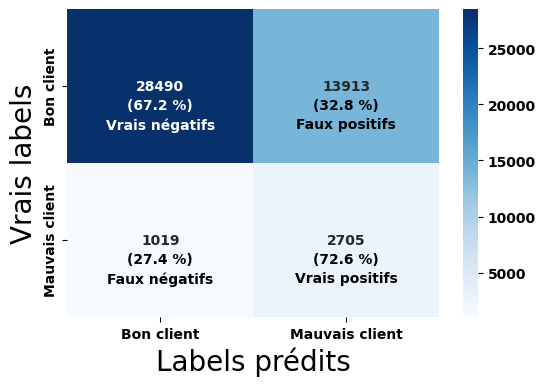

In [19]:
# On instancie le modèle avec les meilleurs paramètres trouvés (différence sur le class_weight)
modele_LR = LogisticRegression(class_weight={0 : .5, 1 : 6.2},
                               C=0.1,
                               max_iter=100, 
                               n_jobs = -1, 
                               random_state = 42)

# On test quelques scaler et un nombre de k feature
param_grid_search = {
    "scaler" : [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "feature_selection__k" : [100, 200]
}

# Permet de sélectionner les colonnes d'intérêts (passer de 700 à 200)
column_selector = SelectColumns(columns=selected_col_ANOVA, ignore_missing=True)
    
pipe = Pipeline([
        ('select_columns', column_selector),
        ('imputer', SimpleImputer(strategy='median')),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('scaler', None),
        ('model', modele_LR)
    ])

# On utilise notre scorer, on veut maximiser le score
# Besoin d'avoir les probabilité
my_scorer = make_scorer(my_custom_scoring, needs_proba = True, greater_is_better=True)
    
# On veut suivre notre scorer et roc_auc
scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc"
    }
grid = GridSearchCV(pipe, param_grid_search, cv = 3, scoring = scorers, refit = "custom_score", verbose = 3)

# On fit sur les données d'entrainement
grid.fit(xtrain, ytrain)

# On récupère les meilleurs paramètres 
best_param_pipe = grid.best_estimator_

# On test sur les données d'entraînements
results_prediction(ytest, best_param_pipe.predict(xtest))

On obtient de très bon résultats avec le scorer développé. 

On peut tenter d'améliorer notre modèle en optimisant le seuil utiliser pour la prédiction (la probabilité) 

### <a name = "T2C2">b. Recherche du meilleur seuil</a>

In [20]:
def search_best_seuil(best_pipe, x, y):
    ##
    #    Fonction permettant de rechercher le meilleur score (selon notre scorer) par rapport au seuil
    #    Premier balayage assez large, puis recherche sur une fenêtre plus petite
    ##
    
    # Pour conserver les résultats
    scores_seuil_1 = []
    scores_seuil_2 = []

    # Itération nestée, pour aller plus vite dans la recherche du meilleur seuil
    for i, scores in enumerate([scores_seuil_1, scores_seuil_2]):
        
        # Première itération, on recherche sur une gamme très haute
        if i == 0:
            fenetre = np.arange(0, 1.01, 0.1)
            
        # Deuxième itération, on recherche sur une gamme plus précise, autour de la meilleur valeur trouvée précédemment
        else :
            fenetre = np.arange(meilleur_seuil - 0.1, meilleur_seuil + 0.1, 0.01)

        # On va tester un certain nombre de valeur de seuil/threshold
        for seuil in fenetre:
            # Prédiction selon le seuil
            predict_pro = (best_pipe.predict_proba(x)[:, 1] >= (seuil)).astype(int)
            
            # On mesure le score métier
            score_metier_seuil = round(my_custom_scoring(y, predict_pro, seuil), 2)
            
            # On stocke le résultat
            scores.append([round(seuil, 2), score_metier_seuil])

        scores = pd.DataFrame(scores, columns = ["Seuil", "Score"])
        
        # On recherche le meilleur score et le meilleur seuil
        meilleur_seuil = scores.loc[scores.Score == scores.Score.max(), "Seuil"].values[0]

        meilleur_score = scores.loc[scores.Score == scores.Score.max(), "Score"].values[0]
        
    # On assemble les 2 scores
    scores_seuil = scores_seuil_1 + scores_seuil_2
    
    # On transforme en dataframe et on élimine les duplicatas
    scores_seuil = pd.DataFrame(scores_seuil, columns = ["Seuil", "Score"]).drop_duplicates()
    
    return scores_seuil, meilleur_seuil, meilleur_score

In [21]:
def affichage_seuil_score(df_score_seuil, b_seuil, b_score):
    ##
    #    Fonction permettant d'afficher les résultats de la recherche de seuil 
    ##
    
    plt.figure(figsize=(8, 6))
    plt.title("Analyse du score par rapport à la valeur seuil\n Meilleur score : {} Meilleur Seuil : {}".format(b_score, b_seuil), 
              size = 20)
    sns.lineplot(df_score_seuil, x = "Seuil", y = "Score", label='Courbe')
    # Pour identifier le meilleur
    plt.scatter(b_seuil, b_score, color='red', label='Meilleur')
    
    # Pour identifier la base
    basique_score = float(df_score_seuil.loc[df_score_seuil.Seuil == 0.5, "Score"])
    
    plt.scatter(0.5, basique_score, color='green', label='Base')
    # Pour identifier l'ensemble des scores > à la valeur de base
    plt.axhline(y=basique_score, color='green', linestyle='--', label = "Basique ligne")

    plt.xlim(0, 1)
    plt.xlabel("Seuils", size = 18)
    plt.ylabel("Scores", size = 18)

    plt.legend()

    plt.show()

In [22]:
scores_seuil, meilleur_seuil, meilleur_score = search_best_seuil(best_param_pipe, xtrain, ytrain)

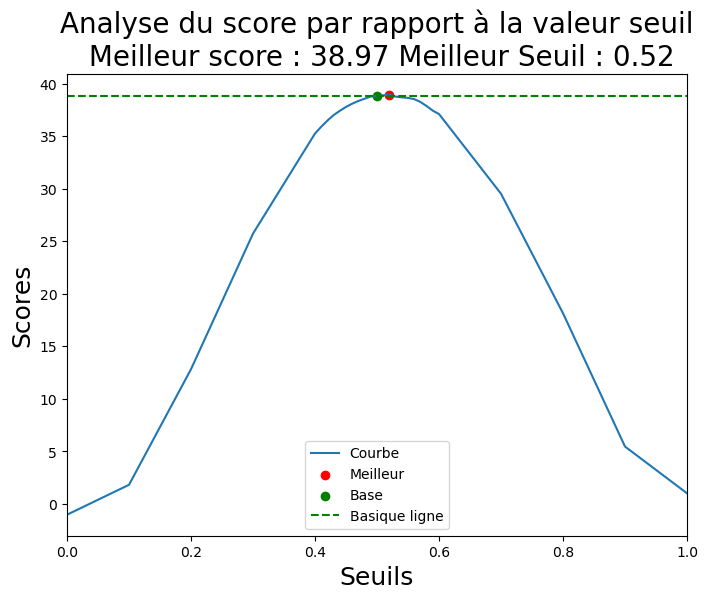

In [23]:
affichage_seuil_score(scores_seuil, meilleur_seuil, meilleur_score)

On observe que le meilleur seuil de prédiction n'est pas à la valeur par défaut 0.5. 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    240279
           1       0.17      0.69      0.27     21101

    accuracy                           0.70    261380
   macro avg       0.56      0.69      0.54    261380
weighted avg       0.90      0.70      0.76    261380



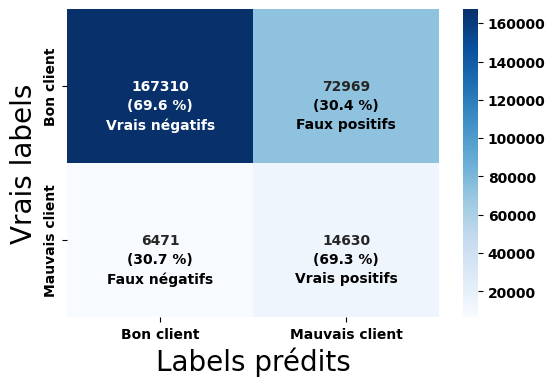

In [24]:
# Données d'entraînements

# Nous réalisons la prédiction avec le meilleur seuil
predict_best_seuil = (best_param_pipe.predict_proba(xtrain)[:, 1] >= (meilleur_seuil)).astype(int)

# On regarde les nouveaux résultats obtenus
results_prediction(ytrain, predict_best_seuil)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     42403
           1       0.17      0.70      0.27      3724

    accuracy                           0.70     46127
   macro avg       0.57      0.70      0.54     46127
weighted avg       0.90      0.70      0.77     46127



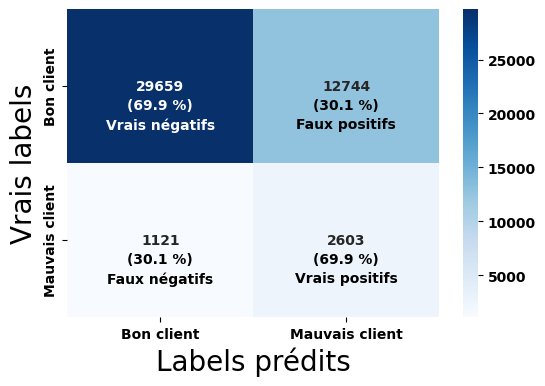

In [25]:
# Données test

# Nous réalisons la prédiction avec le meilleur seuil
predict_best_seuil = (best_param_pipe.predict_proba(xtest)[:, 1] >= (meilleur_seuil)).astype(int)

# On regarde les nouveaux résultats obtenus
results_prediction(ytest, predict_best_seuil)

**Observations** : 

On observe qu'en modifiant le seuil par rapport à la valeur de départ, on diminue légèrement la détection des clients insolvables (augmentation des Faux négatifs et diminution des Vrais positifs) vers une augmentation des clients solvables (augmentation des Vrais négatifs et diminution des Faux positifs). 

A en discuter avec les membres de l'équipe, sur la direction à prendre sur le scorer. On pourrait le modifier pour qu'il tende plus vers la détection des vrais positifs en contrepartie d'une augmentation des faux positifs.

### <a name = "T2C3">c. Recherche des meilleurs hyperparamètres</a>

Maintenant que nous avons développer un score métier pour la recherche des hyperparamètres et d'une valeur seuil, nous allons finaliser le modèle :
- Tester un plus grand nombre d'hyperparamètres.
- Identifier la meilleur valeur seuil pour le score métier.

In [26]:
def explainer_feature_save_model(df, selected_cols, model):
    ##
    #    Fonction permettant de sauvegarder un objet explainer et l'importance des features dans un fichier pickle et csv
    ##
    
    # on génére l'objet explainer
    explainer = shap.LinearExplainer(model, df)
    
    with open('explainer_model.pkl', 'wb') as explainer_file:
        pickle.dump(explainer, explainer_file)
    
    # On récupère les valeurs
    shap_values = explainer(df)
    
    # On mesure l'importance de chaque feature
    average_absolute_shap_values = np.round(np.abs(shap_values.values).mean(axis=0), 2)

    # on crée un dataframe
    shap_values_df = pd.DataFrame({'Features': selected_cols, 'Importance': average_absolute_shap_values})

    # on classe de la feature la plus importante à la plus faible
    shap_values_df = shap_values_df.sort_values(by='Importance', ascending=False)
    
    # On crée le fichier csv
    shap_values_df.to_csv("shap_values_model.csv", index = False, sep = ",")


In [27]:
# Nouvelle version de la fonction search_model_params avec recherche du meilleur seuil 
def search_model_params_score_metier(model_name, model, params, x_train, y_train, x_test, y_test, cols_model, model_type = None):
    
    # Permet de sélectionner les colonnes d'intérêts
    column_selector = SelectColumns(columns=cols_model, ignore_missing=True)
    
    pipe = Pipeline([
            ('select_columns', column_selector),
            ('imputer', SimpleImputer(strategy='median')),
            ('feature_elimination', VarianceThreshold(threshold=0.0)),
            ('feature_selection', SelectKBest(score_func=f_classif)),
            ('scaler', None),
            ('model', model)
        ])

    # On utilise notre scorer, on veut maximiser le score
    # Besoin d'avoir les probabilité
    my_scorer = make_scorer(my_custom_scoring, needs_proba = True, greater_is_better=True)    

    # On crée un dictionnaire qui contiendra les différents scores
    scores = {}

    # On utilise notre scorer, on veut maximiser le score
    my_scorer = make_scorer(my_custom_scoring, needs_proba = True, greater_is_better=True)
    precision_scorer = make_scorer(precision_score, zero_division=1, greater_is_better=True)
    recall_scorer = make_scorer(recall_score, zero_division=1, greater_is_better=True)
    f1_scorer = make_scorer(f1_score, zero_division=1, greater_is_better=True)
    beta = 2
    f_beta_scorer = make_scorer(fbeta_score, zero_division=1, beta=beta, greater_is_better=True)

    # On veut suivre plusieurs scores
    scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc",
    "precision_scorer" : precision_scorer,
    "recall_scorer" : recall_scorer,
    "f1_scorer" : f1_scorer,
    "f_beta" : f_beta_scorer,
    }

    time0 = time.time()

    # On instancie un StratifiedKFold pour garder la répartition dans le gridsearch
    # Je réduit à 3 pour augmenter la vitesse d'éxecution, les tests préliminaires ont montré que 3 était suffisant 
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # On réalise un GridSearchCV pour trouver les meilleurs hyperparamètres pour les modèles de type non "arbre de décision"
    print("Nous testons %d hyperparamètres" %calcul_nombre_hyperparametres(params)) 

    grid = GridSearchCV(pipe, params, cv = stratified_kfold, scoring = scorers, refit = "custom_score", 
                        verbose = 1)


    # On fit sur les données d'entrainement
    grid.fit(x_train, y_train)

    time1 = time.time()

    # On mesure le temps d'entrainement
    scores["training_time"] = round(time1 - time0, 1)

    # On récupère les meilleurs paramètres 
    best_param_pipe = grid.best_estimator_

    # On réalise une cross évaluation
    cross_scores = cross_val_score(best_param_pipe, x_train, y_train, cv=stratified_kfold, scoring=my_scorer)
    print("Cross-validation score : %0.2f avec un écart-type de %0.2f \n" 
              % (cross_scores.mean(), cross_scores.std()))

    # On mesure les différentes métriques et on ajoute au dictionnaire
    scores.update(calcul_scores(best_param_pipe, x_train, y_train, x_test, y_test, beta, my_func = my_custom_scoring))

    # On mesure le temps d'application du meilleur modèle
    scores["elapsed_time"] = round(time.time() - time1, 1)

    # On affiche les différents résultats des métriques
    affichage_score(grid.best_params_, scores)

    # On affiche la matrice de confusion
    results_prediction(y_test, best_param_pipe.predict(x_test))

    # Recherche du meilleur seuil
    scores_seuil, meilleur_seuil, meilleur_score = search_best_seuil(best_param_pipe, x_train, y_train)

    # Affichage de la recherche
    affichage_seuil_score(scores_seuil, meilleur_seuil, meilleur_score)

    new_scores = {"training_time" : scores["training_time"],
                 "elapsed_time" : scores["elapsed_time"]}
    
    # On mesure les nouveaux scores obtenus avec le meilleur seuil
    new_scores.update(calcul_scores(best_param_pipe, 
                                    x_train, 
                                    y_train,
                                    x_test, 
                                    y_test, 
                                    beta, 
                                    meilleur_seuil, 
                                    my_func = my_custom_scoring))

    print("Affichages nouveaux scores avec le meilleur seuil")

    # On affiche les différents résultats des métriques
    affichage_score(grid.best_params_, new_scores)
    
    # on ajoute le score de seuil au modèle
    new_scores["Valeur seuil"] = meilleur_seuil
    
    # Nous réalisons la prédiction avec le meilleur seuil
    predict_best_seuil = (best_param_pipe.predict_proba(x_test)[:, 1] >= (meilleur_seuil)).astype(int)

    # On regarde les nouveaux résultats obtenus
    results_prediction(y_test, predict_best_seuil)

    # On transform x_train selon le pipeline (en enlevant les 2 dernières étapes)
    x_train_preprocessed = best_param_pipe[:-1].transform(x_train)

    # On récupère le nom des colonnes sélectionnées
    selected_cols = xtrain.loc[:, xtrain.columns.isin(cols_model)].columns[grid.best_estimator_['feature_selection'].get_support()]

    affichage_features(best_param_pipe.named_steps['model'], modele_name, selected_cols, x_train_preprocessed, y_train)
    
    # On crée et on sauvegarde un objet explainer et l'importance des features
    # Si on doit expliquer le modèle sur le dashboard
    x_train_preprocessed = pd.DataFrame(x_train_preprocessed, columns = selected_cols)
    explainer_feature_save_model(x_train_preprocessed, selected_cols, best_param_pipe.named_steps['model'])
        
    # On retourne les différentes métriques et le meilleur modèle
    return new_scores, best_param_pipe

In [28]:
mlflow.set_experiment("FINAL_VERSION_Developpement_dun_modele_de_bank_scoring")

<Experiment: artifact_location='file:///C:/Users/33664/Desktop/Data%20scientist%20formation/%5BProjets%5D/Projet%207/mlruns/507354316744477897', creation_time=1693563306046, experiment_id='507354316744477897', last_update_time=1693563306046, lifecycle_stage='active', name='FINAL_VERSION_Developpement_dun_modele_de_bank_scoring', tags={}>

Nous testons 96 hyperparamètres
Fitting 3 folds for each of 96 candidates, totalling 288 fits


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Cross-validation score : 38.52 avec un écart-type de 0.10 




____________________________________________________________________________________________________
Meilleurs paramètres : {'feature_selection__k': 200, 'imputer': SimpleImputer(strategy='median'), 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'sag', 'model__tol': 0.001, 'scaler': StandardScaler()}
Temps de recherche des meilleurs paramètres : 6424.8
Temps d'exécution : 84.7
____________________
Résultats sur échantillons d'entraînement :
Score performance : 38.99 %
Erreur : 30.29 %
ROC_AUC : 0.76
Fbeta-Score : 0.43 
____________________
Résultats sur échantillons de test :
Score performance : 39.92 %
Erreur : 29.94 %
ROC_AUC : 0.77
Precision moyenne : 0.57 
Recall moyen : 0.70 
F1-Score moyen : 0.54 
Fbeta-Score : 0.43 
____________________________________________________________________________________________________



              precision    rec

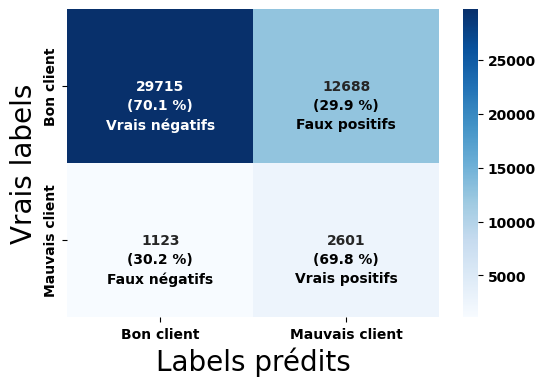

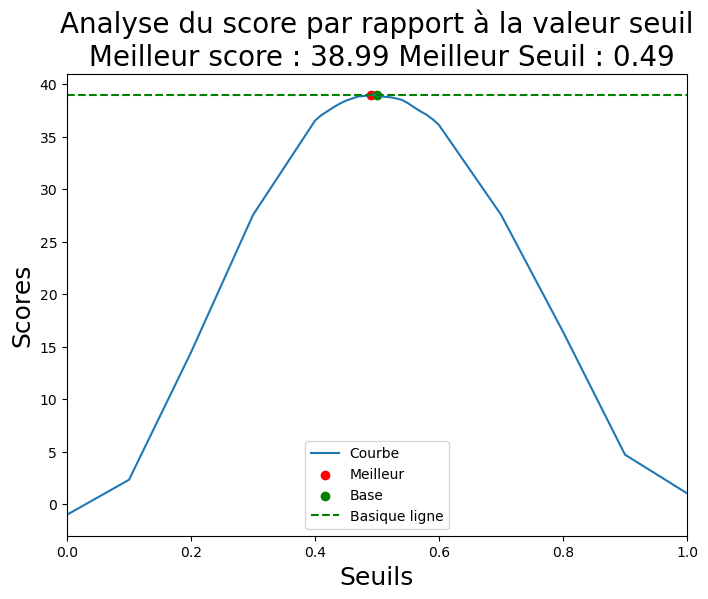

Affichages nouveaux scores avec le meilleur seuil



____________________________________________________________________________________________________
Meilleurs paramètres : {'feature_selection__k': 200, 'imputer': SimpleImputer(strategy='median'), 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'sag', 'model__tol': 0.001, 'scaler': StandardScaler()}
Temps de recherche des meilleurs paramètres : 6424.8
Temps d'exécution : 84.7
____________________
Résultats sur échantillons d'entraînement :
Score performance : 38.99 %
Erreur : 31.43 %
ROC_AUC : 0.76
Fbeta-Score : 0.43 
____________________
Résultats sur échantillons de test :
Score performance : 39.99 %
Erreur : 31.03 %
ROC_AUC : 0.77
Precision moyenne : 0.57 
Recall moyen : 0.70 
F1-Score moyen : 0.54 
Fbeta-Score : 0.43 
____________________________________________________________________________________________________



              precision    recall  f1-sc

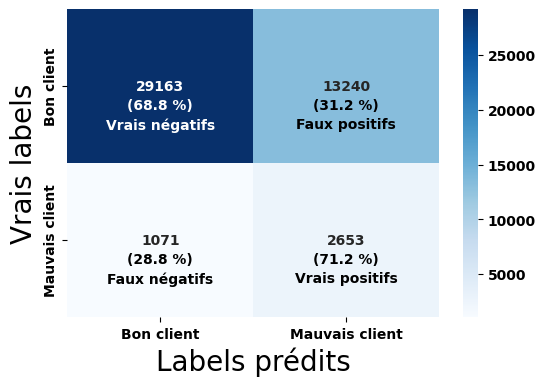

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Setuptools is replacing distutils.


In [29]:
# On instancie le modèle
modele_LR = LogisticRegression(n_jobs = -1, random_state = 42)

modele_name = "LogisticRegression"

model_type = "Regression"

# On test des paramètres proche de ce qu'on a testé (et pré test)
param_grid_search = {
    "imputer" : [SimpleImputer(strategy='median')],
    "scaler" : [StandardScaler()],
    "feature_selection__k" : [150, 200],
    "model__C" : [0.1, 1, 2],
    "model__max_iter" : [100, 1000],
    "model__class_weight" : ['balanced', {0:0.5, 1:6.2}], 
    "model__solver" : ['sag', 'lbfgs'],
    "model__penalty" : ['l2'],
    'model__tol': [1e-4, 1e-3]
}

# On commence l"enregistrement mlflow 
with mlflow.start_run(run_name=modele_name) as run:

    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params_score_metier(modele_name, modele_LR, param_grid_search, 
                                 xtrain, ytrain, xtest, ytest, selected_col_ANOVA, model_type)
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu  
    log_mlflow(param_grid_search, data, dataset_name, results, model)

In [30]:
log_mlflow(param_grid_search, data, dataset_name, results, model)

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


### <a name = "T3C4">d. Quelques observation sur le modèle</a>

Nous avons des scores très corrects (après optimisation du seuil). 

On détecte ~70 % de bon label dans chacune des catégories.

Valeurs de ROC_AUC proche de 0.76-0.77, pas d'overfitting observé.

Le modèle développé est très pertinent pour une utilisation dans le milieu bancaire.

On pourrait modifier le seuil et être plus stringent, pour diminuer les risques de donner un prêt bancaire à un client qui ne saurait pas rembourser.

On peut analyser les avantages d'utiliser le modèle. 

In [31]:
# On analyse les probabilitées données par le modèle sur les valeurs test
proba_0 = model.predict_proba(xtest)[:, 0]
proba_1 = model.predict_proba(xtest)[:, 1]
seuil = results["Valeur seuil"]

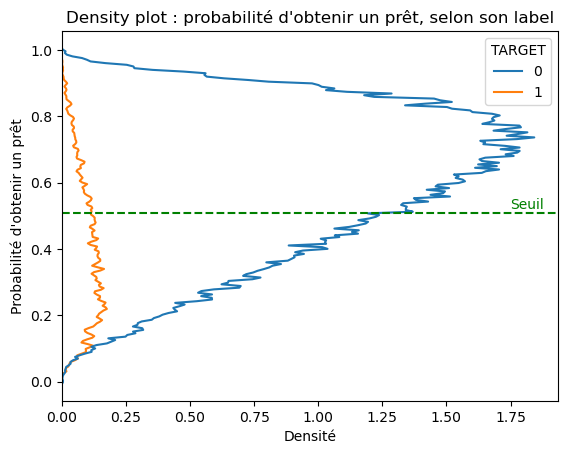

In [32]:
sns.kdeplot(y=proba_0, bw_adjust=.1, hue=ytest)
plt.axhline(y=1-seuil, color='green', linestyle='--', label = "Seuil")
plt.text(1.75, seuil+0.03, "Seuil", c = "green")
plt.title("Density plot : probabilité d'obtenir un prêt, selon son label")
plt.ylabel("Probabilité d'obtenir un prêt")
plt.xlabel("Densité")
plt.show()

On observe la distribution des probabilitées d'obtenir un prêt. 

Ce qu'on observe directement c'est qu'on a bien une distinction > seuil et < seuil. 

In [33]:
bin_range = [i / 10 for i in range(11)] 
bin_labels = [f"{i/10}-{(i+1)/10}" for i in range(10)]  
xtest["bins"] = pd.cut(proba_0, bins=bin_range, labels=bin_labels)

max_bin_0 = xtest[ytest == 0]["bins"].value_counts().idxmax()
max_0 = xtest[ytest == 0]["bins"].value_counts().max()
max_bin_1 = xtest[ytest == 1]["bins"].value_counts().idxmax()
max_1 = xtest[ytest == 1]["bins"].value_counts().max()
print("Maximum de client correctement prédit, pour le label 0 : ", max_bin_0)
print("Maximum de client correctement prédit, pour le label 1 : ", max_bin_1)

Maximum de client correctement prédit, pour le label 0 :  0.7-0.8
Maximum de client correctement prédit, pour le label 1 :  0.2-0.3


On a bien 2 modes, dont les maximums sont assez éloignées du seuil.

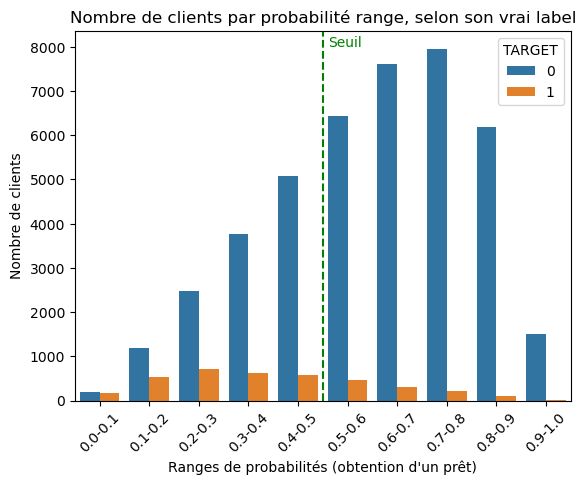

In [34]:
sns.countplot(data = xtest, x = "bins", hue=ytest)
plt.axvline(round((1-seuil)*10) - 0.5, color='green', linestyle='--', label = "Seuil")
plt.text(round((1-seuil)*10)-0.4, 8000, "Seuil", c = "green")
plt.title("Nombre de clients par probabilité range, selon son vrai label")
plt.ylabel("Nombre de clients")
plt.xlabel("Ranges de probabilités (obtention d'un prêt)")
plt.xticks(rotation = 45)
plt.show()

On peut analyser le gain obtenu en utilisant ce modèle par rapport à une attribution au hasard.

In [35]:
proba_generale = ytest[ytest == 0].shape[0] / ytest.shape[0]
print("Sans utilisation du modèle, il y a une probabilité de %.3f de trouver un client solvable" %proba_generale)
print("Cela correspond à un taux d'erreur potentiel de %.1f %%" %(100-proba_generale*100))

Sans utilisation du modèle, il y a une probabilité de 0.919 de trouver un client solvable
Cela correspond à un taux d'erreur potentiel de 8.1 %


In [36]:
proba_generale_sup_thresh = proba_0[(ytest == 0) & (proba_0 > 0.51)].shape[0] / proba_0[proba_0 > 0.51].shape[0]
risque_sup_perc = 100-proba_generale_sup_thresh*100
print("En utilisant le modèle, il y a une probabilité de %.3f de trouver un client solvable" %proba_generale_sup_thresh)
print("Cela correspond à un taux d'erreur potentiel de %.1f %%" %risque_sup_perc)

En utilisant le modèle, il y a une probabilité de 0.965 de trouver un client solvable
Cela correspond à un taux d'erreur potentiel de 3.5 %


In [37]:
proba_generale_inf_thresh = proba_0[(ytest == 0) & (proba_0 <= 0.51)].shape[0] / proba_0[proba_0 <= 0.51].shape[0]
risque_inf_perc = 100-proba_generale_inf_thresh*100
print("En utilisant le modèle, la probabilité de trouver un client solvable sous le seuil est de %.3f " %proba_generale_inf_thresh)
print("Cela correspond à un taux d'erreur potentiel de %.1f %%" %risque_inf_perc)

En utilisant le modèle, la probabilité de trouver un client solvable sous le seuil est de 0.833 
Cela correspond à un taux d'erreur potentiel de 16.7 %


En utilisant le modèle, on peut potentiellement limiter le risque à 3.5 % au lieu de 8.1 %

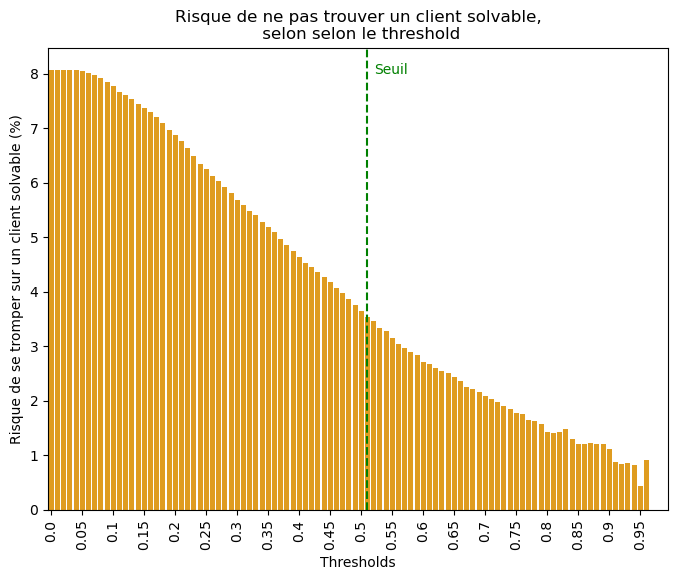

In [20]:
# On mesure le risque pour chaque threshold
risque_pourcent = []
for th in np.arange(0, 1.1, 0.01):
    if proba_0[proba_0 >= th].shape[0] > 0:
        proba_risque = proba_0[(ytest == 0) & (proba_0 >= th)].shape[0] / proba_0[proba_0 >= th].shape[0]
        risque_pourcent.append([round(th, 2), round(100-proba_risque*100, 2)])

risque_pourcent = pd.DataFrame(risque_pourcent, columns = ["Threshold", "Risque"])

plt.figure(figsize=(8,6))
sns.barplot(data = risque_pourcent, x = "Threshold", y = "Risque", color = "orange")
plt.axvline(51, color='green', linestyle='--', label = "Seuil")
plt.text(52, 8, "Seuil", c = "green")
plt.title("Risque de ne pas trouver un client solvable,\n selon selon le threshold")
plt.ylabel("Risque de se tromper sur un client solvable (%)")
plt.xlabel("Thresholds")

plt.xticks(range(0, len(risque_pourcent), 5), rotation=90)
plt.show()

In [21]:
# On garde cette donnée sur le modèle
risque_pourcent.to_csv("Risque assessment.csv", index = False)

In [38]:
proba_list = []
# On calcule le nombre de clients par bins
for b in xtest.bins.sort_values().unique():
    mask = xtest[xtest.bins == b]
    bin_range_proba = mask[ytest == 0].shape[0] / mask.shape[0]
    proba_list.append([b, bin_range_proba, mask.shape[0]])

    print("range : %s, \nproba client solvable %.3f, \nproba erreur %.3f\nnb clients %d\n" %(b, bin_range_proba, 1-bin_range_proba, mask.shape[0]))

proba_list = pd.DataFrame(proba_list, columns = ["Range", "Proba_solvable", "Nb_client"])

range : 0.0-0.1, 
proba client solvable 0.526, 
proba erreur 0.474
nb clients 352

range : 0.1-0.2, 
proba client solvable 0.690, 
proba erreur 0.310
nb clients 1722

range : 0.2-0.3, 
proba client solvable 0.778, 
proba erreur 0.222
nb clients 3171

range : 0.3-0.4, 
proba client solvable 0.857, 
proba erreur 0.143
nb clients 4402

range : 0.4-0.5, 
proba client solvable 0.899, 
proba erreur 0.101
nb clients 5642

range : 0.5-0.6, 
proba client solvable 0.932, 
proba erreur 0.068
nb clients 6916



Boolean Series key will be reindexed to match DataFrame index.


range : 0.6-0.7, 
proba client solvable 0.960, 
proba erreur 0.040
nb clients 7928

range : 0.7-0.8, 
proba client solvable 0.973, 
proba erreur 0.027
nb clients 8180

range : 0.8-0.9, 
proba client solvable 0.985, 
proba erreur 0.015
nb clients 6283

range : 0.9-1.0, 
proba client solvable 0.989, 
proba erreur 0.011
nb clients 1531



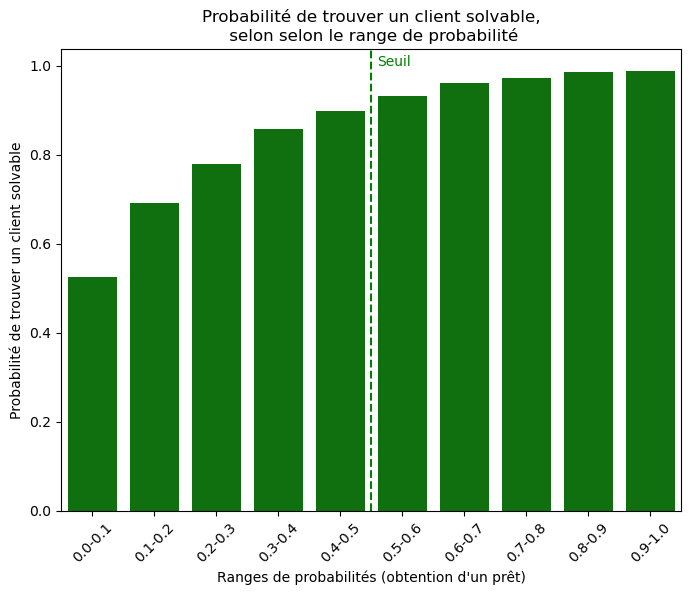

In [39]:
plt.figure(figsize=(8,6))
sns.barplot(data = proba_list, x = "Range", y = "Proba_solvable", color = "green")
plt.axvline(round((1-seuil)*10) - 0.5, color='green', linestyle='--', label = "Seuil")
plt.text(round((1-seuil)*10)-0.4, 1, "Seuil", c = "green")
plt.title("Probabilité de trouver un client solvable,\n selon selon le range de probabilité")
plt.ylabel("Probabilité de trouver un client solvable")
plt.xlabel("Ranges de probabilités (obtention d'un prêt)")
plt.xticks(rotation = 45)
plt.show()

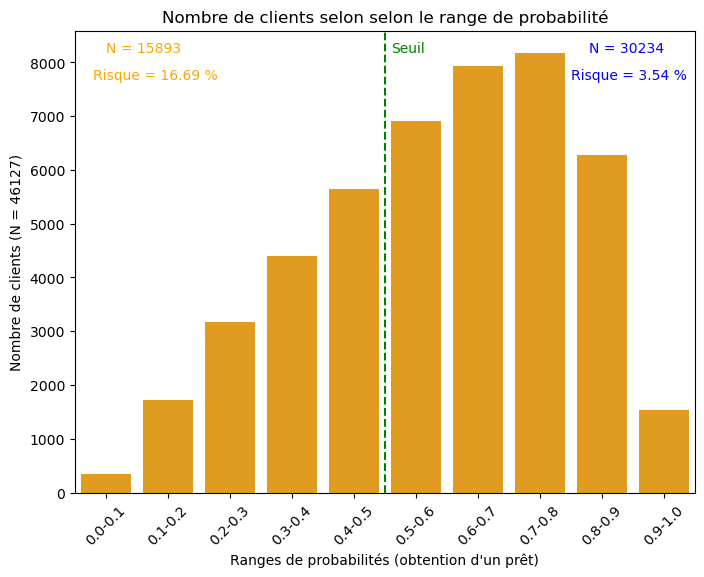

In [40]:
plt.figure(figsize=(8,6))
sns.barplot(data = proba_list, x = "Range", y = "Nb_client", color = "orange")
plt.axvline(round((1-seuil)*10) - 0.5, color='green', linestyle='--', label = "Seuil")
plt.text(round((1-seuil)*10)-0.4, proba_list.Nb_client.max(), "Seuil", c = "green")
plt.text(0, proba_list.Nb_client.max(), f"N = {proba_0[proba_0 <= 1-seuil].shape[0]}", c = "orange")
plt.text(-0.2, proba_list.Nb_client.max()-500, f"Risque = {risque_inf_perc:.2f} %", c = "orange")
plt.text(7.8, proba_list.Nb_client.max(), f"N = {proba_0[proba_0 > 1-seuil].shape[0]}", c = "blue")
plt.text(7.5, proba_list.Nb_client.max()-500, f"Risque = {risque_sup_perc:.2f} %", c = "blue")
plt.title("Nombre de clients selon selon le range de probabilité")
plt.ylabel(f"Nombre de clients (N = {xtest.shape[0]})")
plt.xlabel("Ranges de probabilités (obtention d'un prêt)")
plt.xticks(rotation = 45)
plt.show()

On retombe sur les résultats de la matrice de confusion, mais représenté différement.

Au final, le conseillé bancaire déterminera quel risque il veut prendre pour l'assignation d'un prêt bancaire.

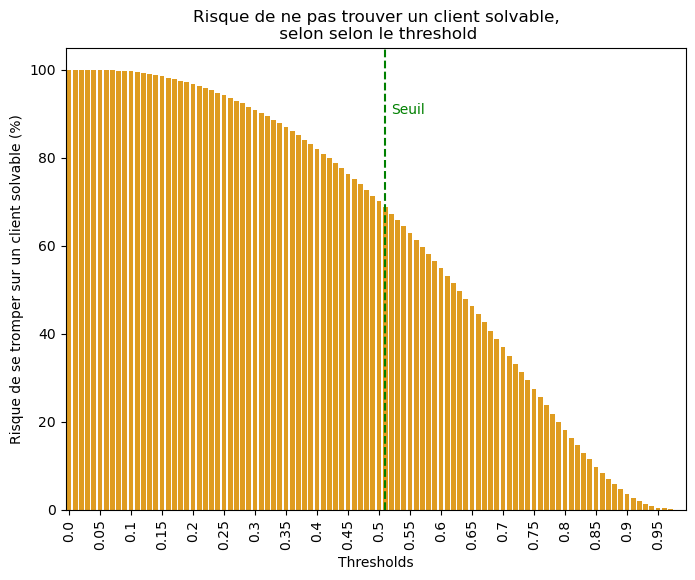

In [32]:
# On mesure le risque pour chaque threshold
nb_client_pourcent = []
for th in np.arange(0, 1.1, 0.01):
    if proba_0[proba_0 >= th].shape[0] > 0:
        # on mesure sur la totalité des clients ayant obtenus un prêt
        nb_client = (proba_0[(ytest == 0) & (proba_0 >= th)].shape[0] 
                     / proba_0[(ytest == 0) & (proba_0 >= 0)].shape[0] * 100)
        nb_client_pourcent.append([round(th, 2), round(nb_client,1)])

nb_client_pourcent = pd.DataFrame(nb_client_pourcent, columns = ["Threshold", "Nombre de clients"])

plt.figure(figsize=(8,6))
sns.barplot(data = nb_client_pourcent, x = "Threshold", y = "Nombre de clients", color = "orange")
plt.axvline(51, color='green', linestyle='--', label = "Seuil")
plt.text(52, 90, "Seuil", c = "green")
plt.title("Risque de ne pas trouver un client solvable,\n selon selon le threshold")
plt.ylabel("Risque de se tromper sur un client solvable (%)")
plt.xlabel("Thresholds")

plt.xticks(range(0, len(risque_pourcent), 5), rotation=90)
plt.show()

On confirme bien qu'au niveau du seuil, on repère au moins 70 % des clients solvables.

In [33]:
# On garde cette donnée sur le modèle
nb_client_pourcent.to_csv("Potentiel clients.csv", index = False)

### <a name = "T3C5">e. Enregistrement du modèle</a>

Nous avons établis que c'était le meilleur modèle, nous allons l'enregistrer pour pouvoir le charger plus tard.

In [41]:
# On récupère l'heure actuelle
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# On crée un nom dynamique pour la génération du modèle
save_model_name = f"banking_model_{timestamp}"
save_seuil_name = f"banking_model_seuil_{timestamp}"

# On enregistre le modèle et le seuil
save_model(model, save_model_name)

with open(f"banking_model_seuil_{timestamp}.pkl", 'wb') as save_seuil:
    pickle.dump(results["Valeur seuil"], save_seuil)


In [42]:
# On test que notre modèle a bien été enregistré et qu'il est chargeable.
test_load_model = mlflow.sklearn.load_model(save_model_name)

test_load_model

Pipeline(steps=[('select_columns',
                 SelectColumns(columns=array(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT...
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'donnees_manquantes'],
      dtype=object),
                               ignore_missing=True)),
                ('imputer', SimpleImputer(strategy='median')),
                ('feature_elimination', VarianceThreshold()),
                ('feature_selection', SelectKBest(k=200)),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='sag',
                                    tol=0.001))])

***
# <a name="T4">Dérive du modèle</a>
### <a name = "T4C1">a. Evidently</a>

Pour tester le data drift, qui correspond à un changement dans la distribution des données. Nous allons tester les données provenant du fichier application_test.csv. Ce fichier n'avait pas été utilisé, car il ne possède pas la valeur TARGET. Pour le data drift, on ne s'en préocupe pas.

In [43]:
path_data = os.getcwd()
# On récupère la liste de fichiers dans le dossier
file_list = os.listdir(path_data + "/fichiers")

# On filtre sur les fichiers csv
csv_files = ["fichiers/" + file for file in file_list if file.endswith('.csv')]

# Si l'opération de merge n'a pas déjà été réalisée, on la réalise
if "fichiers/concatenate_files_data_drift.csv" not in (csv_files):
    print("Préparation du fichier...")
    data_drift = preparation_files(bool_drift = True)

else:
    print("Fichier déjà généré")
    data_drift = pd.read_csv("fichiers/concatenate_files_data_drift.csv")

Fichier déjà généré


In [44]:
data_drift.shape

(48744, 794)

In [47]:
data_drift = reduce_mem_usage(data_drift)

L'utilisation de la mémoire est de 295.28 MB
L'utilisation de la mémoire est de 81.26 MB après optimisation
Réduction de 72.5 %


On peut traiter les données directement à l'aide du pipeline.

In [52]:
# On récupère le nom des features utilisés par le modèle développé
feature_names = model[0].transform(data).columns[model[-3].get_support()]

# On transforme les données selon le modèle (après imputation et standardisation)
data_evidently_model = data.loc[:, data.columns.isin(feature_names)]
data_drift_evidently_model = data_drift.loc[:, data_drift.columns.isin(feature_names)]

In [53]:
# On vérifie que le traitement a été réalisé
print("Données initiales :", data_evidently_model.shape)
print("Données de test : ", data_drift_evidently_model.shape)

Données initiales : (307507, 200)
Données de test :  (48744, 200)


### <a name = "T3C2">b. Résultat</a>

In [54]:
# On récupère les features importance
features_importance = pd.DataFrame([feature_names, abs(model[-1].coef_[0])]).transpose()
features_importance = features_importance.rename(columns={0: "Features", 1: "Coefficients"})
# on trie
features_importance = features_importance.sort_values("Coefficients", ascending = False)
features_importance

,Features,Coefficients
16,EXT_SOURCE_3,0.409919
15,EXT_SOURCE_2,0.378231
127,PREV_CNT_PAYMENT_MEAN,0.221959
0,CODE_GENDER,0.187111
170,PREV_NAME_YIELD_GROUP_low_action_MEAN,0.168979
...,...,...
137,PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs_MEAN,0.001516
17,OBS_30_CNT_SOCIAL_CIRCLE,0.00149
136,PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN,0.001477
189,INSTAL_DPD_SUM,0.000834


In [57]:
path_data = "data_drift_rapport"
# Dossier contenant les rapports
data_drift_dossier = "data_drift_rapport"

combined_html_file = "final_data_drift_rapport.html"

# On vérifie si un fichier a déjà été généré ou non
if os.path.isfile(os.path.join(path_data, combined_html_file)):
    # Si oui, on affiche le fichier
    display(IFrame(os.path.join(path_data, combined_html_file), width=1000, height=1000))
    
else:
    # On génére un dossier si aucun n'est crée
    if not os.path.exists(data_drift_dossier):
        os.makedirs(data_drift_dossier)
    
    # Permet de contenir le nom des fichiers pour concatenate ensuite
    report_paths = []
    number = 0
    # Nombre de features par rapport
    nb_var = 20
    # On génére les rapport par tranche, sinon ça prend trop de temps de calcul (division par 20 features, en partant des plus importantes)
    for i in range(0,len(features_importance), nb_var):
        print("Progression %d %%" %(((i+nb_var) /len(features_importance))*100), end='\r')

        features = features_importance.iloc[i:i+nb_var, 0].values

        # On crée le rapport
        data_drift_report = Report(metrics=[DataDriftPreset(),])
        mask1 = data_evidently_model.loc[:, data_evidently_model.columns.isin(features)]
        mask2 = data_drift_evidently_model.loc[:, data_drift_evidently_model.columns.isin(features)]
        data_drift_report.run(current_data=mask2.astype(np.float64), 
                          reference_data=mask1.astype(np.float64), 
                          column_mapping=None)

        # On sauvegarde les rapports
        html_file_name = f"data_drift_rapport/rapport_{number}.html"

        # On sauvegarde le fichier au format html
        data_drift_report.save_html(html_file_name)

        # On ajoute à la liste
        report_paths.append(html_file_name)

        number += 1
    combined_html_file = "data_drift_rapport/final_data_drift_rapport.html"
    
    # On combine l'ensemble des rapports
    with open(combined_html_file, "w") as combined_report:
        for report_path in report_paths:
            with open(report_path, "r", errors='ignore') as individual_report:
                combined_report.write(individual_report.read())
            os.remove(report_path)
    
    
    if os.path.isfile(combined_html_file):
        display(IFrame(combined_html_file, width=1000, height=1000))



Nous avons très peu de data_drift, seulement 10 variables.

Seulement sur les 3-4 premières ce drift est important.

Donc, le modèle identifié restera assez pertinent.